# Text Classification

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print('TensorFlow version: ', tf.__version__)

TensorFlow version:  1.13.1


## IMDB dataset のダウンロード
- レビューが整数の配列に変換されたデータセット
- 整数が辞書中の特定の単語を表す

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## データを調べる
- サンプルそれぞれが映画レビューの中の単語を表す整数の配列
- ラベル
    - 0 : 否定的なレビュー
    - 1 : 肯定的なレビュー

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


レビューの長さはそれぞれ異なる
- ニューラルネットワークへの入力は同じ長さでなければならない

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

## 整数を単語に戻す

In [6]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k: (v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [7]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

```decode_review``` を使うとレビューのテキストを表示できる

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## データの準備
レビューはニューラルネットワークに投入する前にテンソルに変換する必要がある
- one-hot encoding と同じように単語の出現を表す 0 と 1 のベクトルに変換する
- 配列をパディングによって同じ長さに揃え， ```サンプル数 * 長さの最大値``` の形の整数テンソルにする

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

パディング後のサンプルの長さを見てみる

In [10]:
print('sample0: %d, sample1: %d' % (len(train_data[0]), len(train_data[1])))

sample0: 256, sample1: 256


In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## モデルの構築
２つの大きな決定が必要
1. モデルに幾つの層を設けるか？
2. 層ごとに何個の隠れユニットを使用するか？

In [12]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 分類器を構成するために一列に積み重ねられる
#### 1. 最初の層は ```Embedding``` （埋め込み）層
- 整数にエンコードされた語彙を受け取り，インデックスに対応する埋め込みベクトルを検索
- 埋め込みベクトルはモデルの訓練の中で学習
- 出力行列には次元が１つ追加 ```(batch, sequence, embedding)```

#### 2. 次は ```GlobalAveragePooling1D``` 層
- それぞれのサンプルについて，シーケンス次元方向に平均値をもとめ，固定長のベクトルを返す

#### 3. 固定長の出力ベクトルは，16個の隠れユニットを持つ全結合（```Dense```）層に受け渡し
#### 4. 最後の層は1個の出力ノードに全結合

### 隠れユニット
2つの隠れ層がある
- 出力は，その層の内部表現の次元数
- ネットワークが学習によって内部表現を獲得する際の自由度

### 損失関数とオプティマイザ

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 検証用データを作る
### 10,000個のサンプルを取り分けて検証用データを作る
- 訓練用データだけを使って，モデルの開発とチューニングを行う
- テスト用データを1回だけ使い，正解率を検証

In [14]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## モデルの訓練
512個のサンプルからなるミニバッチを使って，40エポックモデルを訓練

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 57us/sample - loss: 0.6925 - acc: 0.5122 - val_loss: 0.6911 - val_acc: 0.5697
Epoch 2/40
15000/15000 [==============================] - 1s 37us/sample - loss: 0.6879 - acc: 0.6525 - val_loss: 0.6845 - val_acc: 0.7167
Epoch 3/40
15000/15000 [==============================] - 1s 37us/sample - loss: 0.6776 - acc: 0.7381 - val_loss: 0.6714 - val_acc: 0.7508
Epoch 4/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6590 - acc: 0.7495 - val_loss: 0.6495 - val_acc: 0.7579
Epoch 5/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6296 - acc: 0.7846 - val_loss: 0.6176 - val_acc: 0.7794
Epoch 6/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.5899 - acc: 0.8048 - val_loss: 0.5783 - val_acc: 0.7946
Epoch 7/40
15000/15000 [==============================] - 1s 35us/sa

## モデルの評価
２つの値
- 損失
- 正解率

In [16]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 36us/sample - loss: 0.3352 - acc: 0.8714
[0.3351935883569717, 0.87144]


## 正解率と損失の時系列グラフ

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

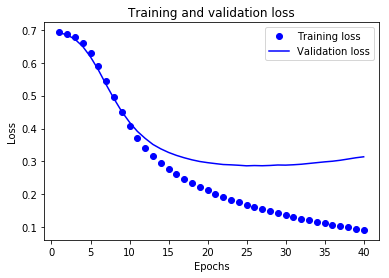

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" は青いドット
plt.plot(epochs, loss, 'bo', label='Training loss')
# ”b" は青い実線
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

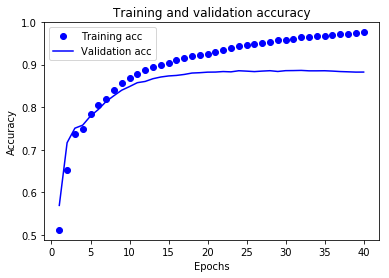

In [19]:
plt.clf()   # 図のクリア
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 損失がエポックごとに減少
### 正解率がエポックごとに上昇